<a href="https://colab.research.google.com/github/YossefMohamed/covid-19_model/blob/main/Copy_of_second_cough_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras import Sequential,Model
from keras.layers import concatenate,Activation, Dense, Dropout, Conv2D, Flatten, MaxPooling2D, GlobalMaxPooling2D, GlobalAveragePooling1D, AveragePooling2D, Input, Add, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.models import model_from_json
from sklearn.metrics import roc_curve
from keras.utils import np_utils
from tqdm import tqdm
import pandas as pd
import numpy as np
import librosa 
import librosa.display
import pylab
import cv2
import os

---
# 1-Prepare Data
---



## Download Data

In [ ]:
!git clone https://github.com/iiscleap/Coswara-Data.git

Cloning into 'Coswara-Data'...
remote: Enumerating objects: 775, done.
remote: Counting objects: 100% (13/13), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 775 (delta 1), reused 10 (delta 1), pack-reused 762
Receiving objects: 100% (775/775), 14.63 GiB | 43.88 MiB/s, done.
Resolving deltas: 100% (303/303), done.
Checking out files: 100% (186/186), done.


In [ ]:
rt_dir = '/content/Coswara-Data'
import glob
for each in os.listdir(rt_dir):
    if os.path.isdir(os.path.join(rt_dir,each)) and each != '.git':
        print(each)
        !cat {os.path.join(rt_dir, each,'')}*.tar.gz.* > {os.path.join(rt_dir, each,'')}combined_file.tar.gz
        !tar -xzf {os.path.join(rt_dir, each,'')}combined_file.tar.gz -C {rt_dir}
subset = glob.glob('/content/Coswara-Data/*/*.tar.gz.*') + glob.glob('/content/Coswara-Data/*/combined_data.tar.gz')
[os.remove(x) for x in subset];

20200418
20200504
20210630
20200720
20210206
20210603
20201012
20210714
20200919
20200824
20201130
20210816
20200820
20200430
20200424
20201031
20200416
20210830
20210523
20210618
20200707
20200413
20200604
20210406
20200419
20200415
20200901
20200505
20210426
20200502
20210419
20220116
20200525
20210930
20200911
20200814
20200803
20210914
20201221
20200417
20200930
20210507


In [2]:
!wget https://zenodo.org/record/4048312/files/public_dataset.zip?download=1
!mv public_dataset.zip?download=1 public_dataset.zip
!unzip -q public_dataset.zip
!mkdir 'custom_dataset'

--2022-02-14 20:15:18--  https://zenodo.org/record/4048312/files/public_dataset.zip?download=1
Resolving zenodo.org (zenodo.org)... 137.138.76.77
Connecting to zenodo.org (zenodo.org)|137.138.76.77|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 951442487 (907M) [application/octet-stream]
Saving to: ‘public_dataset.zip?download=1’

public_dataset.zip? 100%[===================>] 907.37M  1.60MB/s    in 4m 59s  

2022-02-14 20:20:19 (3.04 MB/s) - ‘public_dataset.zip?download=1’ saved [951442487/951442487]



In [ ]:
names   = ['ID','Fever/MP','ORC','STATUS','DIR','DataSet']
join_by = pd.read_csv('/content/Coswara-Data/combined_data.csv')

import glob
df_list = []
for path in tqdm(glob.glob('/content/Coswara-Data/*/*/cough-shallow.wav')):
  temp = pd.DataFrame(columns=['id','DIR'])
  temp['id'] = [path.split('/')[-2]]
  temp['DIR'] = [path]
  temp = pd.merge(left=temp,right=join_by,on='id',how='inner')

  temp['fomp']= (temp['fever']| temp['mp']).apply(int)
  temp['oths']= (temp['cld']|temp['asthma']|temp['cold']|temp['st']|temp['pneumonia']).apply(int)
  temp        = temp[['id','covid_status','DIR','fomp','oths']]
  df_list.append(temp.rename(columns={'id':'ID','covid_status':'STATUS','DIR':'DIR','fomp':'Fever/MP','oths':'ORC'}))
CosData1=pd.concat(df_list)
CosData1['DataSet'] = 'coswara'
CosData1.head()

100%|██████████| 2373/2373 [00:37<00:00, 63.12it/s]


,ID,STATUS,DIR,Fever/MP,ORC,DataSet
0,xyM7qnHrkeSfQsGyRCsomcKfMDG3,healthy,/content/Coswara-Data/20200419/xyM7qnHrkeSfQsG...,0,0,coswara
0,RgfYXoDTg6MBu6V0xKMEjsMfY8m2,no_resp_illness_exposed,/content/Coswara-Data/20200419/RgfYXoDTg6MBu6V...,0,0,coswara
0,OnSOmvzzE2WLcwfrSyNbh0B89n72,resp_illness_not_identified,/content/Coswara-Data/20200419/OnSOmvzzE2WLcwf...,0,0,coswara
0,MEEGIoNSX4exg4oIL3Q9MdysPJq1,healthy,/content/Coswara-Data/20200419/MEEGIoNSX4exg4o...,0,0,coswara
0,Uy5OhcHEQXY65CsYbiRPtN7RVBf1,healthy,/content/Coswara-Data/20200419/Uy5OhcHEQXY65Cs...,0,0,coswara


In [ ]:
positive_mild = CosData1.loc[CosData1['STATUS']=='positive_mild']
positive_moderate	 = CosData1.loc[CosData1['STATUS']=='positive_moderate']
positive_asymp = CosData1.loc[CosData1['STATUS']=='positive_asymp']

positive = pd.concat([positive_mild,positive_moderate,positive_asymp])

healthy = CosData1.loc[CosData1['STATUS']=='healthy']
resp_illness_not_identified = CosData1.loc[CosData1['STATUS']=='resp_illness_not_identified']
no_resp_illness_exposed = CosData1.loc[CosData1['STATUS']=='no_resp_illness_exposed']
recovered_full = CosData1.loc[CosData1['STATUS']=='recovered_full']

negative =  pd.concat([healthy,resp_illness_not_identified,no_resp_illness_exposed,recovered_full])

print(len(positive))
print(len(negative))

f_negative = negative.loc[negative['STATUS']!='COVID-19'][0:550]
print(len(f_negative))



522
1851
550


In [ ]:
CosData   = pd.concat([positive,f_negative])
CosData   = CosData.sample(frac=1)

CosData.head()

,ID,STATUS,DIR,Fever/MP,ORC,DataSet
0,OC99RqHzOjNvaA0rJhPUgP4PM2o1,healthy,/content/Coswara-Data/20210830/OC99RqHzOjNvaA0...,0,0,coswara
0,Fh3hBZZRh2UXXicTNGMei8ikbSu2,positive_asymp,/content/Coswara-Data/20210406/Fh3hBZZRh2UXXic...,0,0,coswara
0,ZIsSazVaDRZmnV0GzL164wnjQGV2,healthy,/content/Coswara-Data/20200417/ZIsSazVaDRZmnV0...,0,0,coswara
0,R4AY1hLOZtUJRsYeDGgGZR4sKVP2,healthy,/content/Coswara-Data/20200424/R4AY1hLOZtUJRsY...,0,0,coswara
0,HK3FfcI5SyXc7CtQMaQiMQ2ia1n2,positive_asymp,/content/Coswara-Data/20210603/HK3FfcI5SyXc7Ct...,0,0,coswara


## Prepare dataset

In [10]:
coughvid  = '/content/public_dataset/'
custpath  = '/content/custom_dataset/' #Where mel spec images will be stored

VidData   = pd.read_csv(os.path.join(coughvid,'metadata_compiled.csv'),header=0)
VidData   = VidData.loc[VidData['cough_detected'] >= 0.9][['uuid','fever_muscle_pain','respiratory_condition','status']]
VidData.dropna(inplace=True)

extradata = VidData.loc[VidData['status']=='COVID-19']
notradata = VidData.loc[VidData['status']!='COVID-19']

TotData   = pd.concat([extradata,notradata],ignore_index= True)
TotData['DIR'] = coughvid + TotData['uuid'] + '.webm'
TotData['DataSet'] = 'coughvid'
TotData['fever_muscle_pain']    = TotData['fever_muscle_pain'].apply(int)
TotData['respiratory_condition']= TotData['respiratory_condition'].apply(int)
## TotData   = pd.concat([CosData,TotData.rename(columns={'uuid':'ID','status':'STATUS','fever_muscle_pain':'Fever/MP','respiratory_condition':'ORC'})])
TotData   = TotData.rename(columns={'uuid':'ID','status':'STATUS','fever_muscle_pain':'Fever/MP','respiratory_condition':'ORC'})
TotData   = TotData.sample(frac=1).reset_index(drop=True)
TotData.head()

,ID,Fever/MP,ORC,STATUS,DIR,DataSet
0,6f52783a-df32-47e7-8429-e2ec42926fd9,0,0,symptomatic,/content/public_dataset/6f52783a-df32-47e7-842...,coughvid
1,fb880c3c-ca39-4456-80f2-a5f6c20614ae,0,0,healthy,/content/public_dataset/fb880c3c-ca39-4456-80f...,coughvid
2,79a12ab8-7497-4a70-871f-5486c6699f45,0,0,symptomatic,/content/public_dataset/79a12ab8-7497-4a70-871...,coughvid
3,6d9ea08f-896a-4320-92ec-4eb20c59a18c,0,0,healthy,/content/public_dataset/6d9ea08f-896a-4320-92e...,coughvid
4,4c0d7af1-ab1c-4cc9-a7e7-1de5222363c2,0,0,healthy,/content/public_dataset/4c0d7af1-ab1c-4cc9-a7e...,coughvid


In [11]:
TotData2 = TotData["STATUS"].unique()
print(TotData2)

['symptomatic' 'healthy' 'COVID-19']


In [89]:
covid_TotData = TotData[TotData["STATUS"] == "COVID-19" ]
symptomatic_TotData = TotData[TotData["STATUS"] == "symptomatic" ]
healthy_TotData = TotData[TotData["STATUS"] == "healthy" ]

print(len(covid_TotData) , len(symptomatic_TotData) , len(healthy_TotData))
covid_TotData.head()




441 949 4702


,ID,Fever/MP,ORC,STATUS,DIR,DataSet
13,46c6c8ef-8b3d-42a1-b4a1-e86e6aeb1664,1,1,COVID-19,/content/public_dataset/46c6c8ef-8b3d-42a1-b4a...,coughvid
29,40de29df-7881-4cbf-9339-809f6a48ba39,0,0,COVID-19,/content/public_dataset/40de29df-7881-4cbf-933...,coughvid
42,e58d45f3-7d6e-48e6-801b-eafc15f1ec85,1,1,COVID-19,/content/public_dataset/e58d45f3-7d6e-48e6-801...,coughvid
43,015ec831-e765-44ee-aefc-10dfd95dec78,1,1,COVID-19,/content/public_dataset/015ec831-e765-44ee-aef...,coughvid
51,25b750e5-8a76-4c13-9fd8-851e45d1b5ed,0,1,COVID-19,/content/public_dataset/25b750e5-8a76-4c13-9fd...,coughvid


# Data Augmentaion

In [ ]:
pip install audiomentations

In [16]:
from audiomentations import Compose, AddGaussianNoise, TimeStretch, PitchShift, Shift
import soundfile as sf
import librosa

In [ ]:
augment = Compose([
    AddGaussianNoise(min_amplitude=0.001, max_amplitude=0.015, p=0.5),
    TimeStretch(min_rate=0.8, max_rate=1.25, p=0.5),
    PitchShift(min_semitones=-4, max_semitones=4, p=0.5),
    Shift(min_fraction=-0.5, max_fraction=0.5, p=0.5),
])

#/content/Agrenadier_Moat1.wav
for audio_file in tqdm(covid_TotData["DIR"]):
  idx=0
  try:
    samples, sr = librosa.load(audio_file) #get audio file from dataset
    augmented_sample = augment(samples=samples, sample_rate=sr)
    sf.write("/content/augmented_data/" + audio_file.split("/")[-1][0:-5] + ".wav", augmented_sample, sr) #write with wav extantion
    print("\nhi")
    augment_positive_samples = augment_positive_samples.append(covid_TotData.loc[covid_TotData['ID'] == str( audio_file.split("/")[-1][0:-5])],ignore_index=True)
    if idx==5:
      break;
  except:
    print("\n Null File") 
  idx=idx + 1
print(augment_positive_samples.head())

In [126]:
print(augment_positive_samples)

NameError: ignored

## Feature Extraction

In [ ]:
def feature_extractor(row):

  name     = row[0]
  try:
    audio,sr = librosa.load(row[-4])
    #For MFCCS 
    mfccs    = librosa.feature.mfcc(y=audio,sr=sr, n_mfcc=13)
    mfccsscaled = np.mean(mfccs.T,axis=0)
    
    #Mel Spectogram
    pylab.axis('off') # no axis
    pylab.axes([0., 0., 1., 1.], frameon=False, xticks=[], yticks=[])
    melspec  = librosa.feature.melspectrogram(y=audio,sr=sr)
    s_db     = librosa.power_to_db(melspec, ref=np.max)
    librosa.display.specshow(s_db)

    savepath = os.path.join(custpath,name+'.png')
    pylab.savefig(savepath, bbox_inches=None, pad_inches=0)
    pylab.close()
  except:
    print('File cannot open')
    return None,None
  return mfccsscaled,savepath

features = []
diagnoses= []
imgpaths = []

In [ ]:
for row in tqdm(TotData.values):
  mfccs,savepath  = feature_extractor(row)
  features.append(mfccs)
  imgpaths.append(savepath)
  diagnoses.append([row[3],row[4]])

  0%|          | 1/1954 [00:02<1:31:19,  2.81s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  0%|          | 6/1954 [00:10<41:12,  1.27s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  1%|          | 10/1954 [00:13<26:02,  1.24it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  1%|          | 14/1954 [00:15<17:53,  1.81it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  1%|          | 19/1954 [00:18<19:00,  1.70

File cannot open


  1%|▏         | 27/1954 [00:24<23:28,  1.37it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  1%|▏         | 29/1954 [00:26<24:09,  1.33it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  2%|▏         | 33/1954 [00:29<22:08,  1.45it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  2%|▏         | 35/1954 [00:31<26:25,  1.21it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  2%|▏         | 38/1954 [00:32<18:28,  1.73

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  5%|▍         | 93/1954 [01:20<20:58,  1.48it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  5%|▍         | 95/1954 [01:22<21:34,  1.44it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  5%|▍         | 96/1954 [01:23<26:04,  1.19it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  5%|▌         | 102/1954 [01:27<16:47,  1.84it/s]/usr/local/lib/python3.7/dist-packages/libr

File cannot open


  5%|▌         | 104/1954 [01:27<15:01,  2.05it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  6%|▌         | 108/1954 [01:32<25:57,  1.18it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  6%|▌         | 109/1954 [01:33<27:42,  1.11it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  6%|▌         | 110/1954 [01:33<27:56,  1.10it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  6%|▌         | 112/1954 [01:35<22:11, 

File cannot open


  6%|▋         | 127/1954 [01:42<12:25,  2.45it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  7%|▋         | 132/1954 [01:45<15:37,  1.94it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  7%|▋         | 133/1954 [01:46<21:49,  1.39it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  7%|▋         | 134/1954 [01:47<26:13,  1.16it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  7%|▋         | 139/1954 [01:51<18:08, 

File cannot open


  8%|▊         | 161/1954 [02:09<16:59,  1.76it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  8%|▊         | 163/1954 [02:11<22:24,  1.33it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  8%|▊         | 166/1954 [02:14<22:33,  1.32it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  9%|▉         | 174/1954 [02:19<20:47,  1.43it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  9%|▉         | 175/1954 [02:20<22:06, 

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 12%|█▏        | 234/1954 [03:13<26:18,  1.09it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 12%|█▏        | 239/1954 [03:16<18:30,  1.54it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 12%|█▏        | 240/1954 [03:18<31:26,  1.10s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 12%|█▏        | 242/1954 [03:20<24:41,  1.16it/s]/usr/local/lib/python3.7/dist-packages/l

File cannot open


 20%|██        | 396/1954 [05:37<19:17,  1.35it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 20%|██        | 397/1954 [05:38<23:31,  1.10it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 20%|██        | 398/1954 [05:40<26:55,  1.04s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 20%|██        | 399/1954 [05:41<31:51,  1.23s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 20%|██        | 400/1954 [05:43<33:33, 

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 21%|██▏       | 419/1954 [05:59<15:36,  1.64it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 22%|██▏       | 422/1954 [06:01<14:10,  1.80it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 22%|██▏       | 423/1954 [06:02<20:41,  1.23it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 22%|██▏       | 427/1954 [06:05<15:01,  1.69it/s]/usr/local/lib/python3.7/dist-packages/l

File cannot open


 30%|██▉       | 583/1954 [08:17<17:49,  1.28it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 30%|██▉       | 584/1954 [08:18<20:47,  1.10it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 30%|██▉       | 586/1954 [08:19<17:51,  1.28it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 30%|███       | 587/1954 [08:21<22:04,  1.03it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 30%|███       | 589/1954 [08:22<19:53, 

File cannot open


 31%|███▏      | 612/1954 [08:41<13:07,  1.70it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 32%|███▏      | 616/1954 [08:44<14:56,  1.49it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 32%|███▏      | 617/1954 [08:46<19:13,  1.16it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 32%|███▏      | 618/1954 [08:47<23:02,  1.03s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 32%|███▏      | 619/1954 [08:48<23:33, 

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 42%|████▏     | 828/1954 [12:04<17:46,  1.06it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 42%|████▏     | 829/1954 [12:05<21:45,  1.16s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 43%|████▎     | 832/1954 [12:08<17:09,  1.09it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 43%|████▎     | 834/1954 [12:10<16:53,  1.11it/s]/usr/local/lib/python3.7/dist-packages/l

File cannot open


 43%|████▎     | 838/1954 [12:12<10:37,  1.75it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 43%|████▎     | 842/1954 [12:16<12:14,  1.51it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 43%|████▎     | 843/1954 [12:17<17:13,  1.08it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 43%|████▎     | 844/1954 [12:19<20:10,  1.09s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 43%|████▎     | 845/1954 [12:20<22:05, 

File cannot open


 48%|████▊     | 937/1954 [13:50<12:02,  1.41it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 48%|████▊     | 939/1954 [13:52<13:43,  1.23it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 48%|████▊     | 942/1954 [13:54<11:36,  1.45it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 48%|████▊     | 945/1954 [13:56<11:29,  1.46it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 48%|████▊     | 947/1954 [13:58<12:41, 

File cannot open


 58%|█████▊    | 1126/1954 [17:04<10:51,  1.27it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 58%|█████▊    | 1127/1954 [17:06<14:43,  1.07s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 58%|█████▊    | 1128/1954 [17:07<16:12,  1.18s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 58%|█████▊    | 1129/1954 [17:08<14:00,  1.02s/it]

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 58%|█████▊    | 1130/1954 [17:10<17:05,  1.24s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 58%|█████▊    | 1131/1954 [17:11<19:15,  1.40s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 58%|█████▊    | 1133/1954 [17:14<16:34,  1.21s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 58%|█████▊    | 1136/1954 [17:17<13:13,  1.03it/s]/usr/local/lib/python3.7/dist-packag

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 58%|█████▊    | 1139/1954 [17:20<13:38,  1.00s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 58%|█████▊    | 1140/1954 [17:21<15:01,  1.11s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 58%|█████▊    | 1141/1954 [17:23<17:53,  1.32s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 58%|█████▊    | 1142/1954 [17:25<19:44,  1.46s/it]/usr/local/lib/python3.7/dist-packag

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 60%|█████▉    | 1167/1954 [17:51<12:41,  1.03it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 60%|█████▉    | 1169/1954 [17:53<13:11,  1.01s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 60%|█████▉    | 1170/1954 [17:55<15:59,  1.22s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 60%|█████▉    | 1171/1954 [17:57<18:19,  1.40s/it]/usr/local/lib/python3.7/dist-packag

File cannot open


 63%|██████▎   | 1231/1954 [19:03<10:08,  1.19it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 63%|██████▎   | 1233/1954 [19:05<11:34,  1.04it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 63%|██████▎   | 1235/1954 [19:08<12:32,  1.05s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 63%|██████▎   | 1237/1954 [19:10<12:26,  1.04s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 63%|██████▎   | 1239/1954 [19:12<12

File cannot open


 65%|██████▍   | 1262/1954 [19:34<05:14,  2.20it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 65%|██████▍   | 1265/1954 [19:37<07:44,  1.48it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 65%|██████▍   | 1267/1954 [19:39<09:28,  1.21it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 65%|██████▍   | 1269/1954 [19:42<11:22,  1.00it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 65%|██████▌   | 1271/1954 [19:44<11

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 66%|██████▌   | 1285/1954 [20:00<11:28,  1.03s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 66%|██████▌   | 1289/1954 [20:03<07:55,  1.40it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 66%|██████▌   | 1290/1954 [20:05<11:18,  1.02s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 66%|██████▌   | 1293/1954 [20:08<09:40,  1.14it/s]/usr/local/lib/python3.7/dist-packag

File cannot open


 67%|██████▋   | 1301/1954 [20:13<06:35,  1.65it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 67%|██████▋   | 1304/1954 [20:16<07:40,  1.41it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 67%|██████▋   | 1305/1954 [20:17<10:19,  1.05it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 67%|██████▋   | 1307/1954 [20:20<11:07,  1.03s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 67%|██████▋   | 1308/1954 [20:22<13

File cannot open


 67%|██████▋   | 1313/1954 [20:27<10:57,  1.02s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 67%|██████▋   | 1315/1954 [20:30<11:51,  1.11s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 67%|██████▋   | 1316/1954 [20:32<14:12,  1.34s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 68%|██████▊   | 1319/1954 [20:35<10:28,  1.01it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 68%|██████▊   | 1321/1954 [20:37<10

File cannot open


 73%|███████▎  | 1434/1954 [22:52<05:59,  1.44it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 74%|███████▎  | 1439/1954 [22:56<05:25,  1.58it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 74%|███████▎  | 1440/1954 [22:58<08:49,  1.03s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 74%|███████▎  | 1441/1954 [23:00<11:19,  1.33s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 74%|███████▍  | 1445/1954 [23:03<07

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 80%|████████  | 1568/1954 [25:23<06:47,  1.06s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 80%|████████  | 1571/1954 [25:26<05:50,  1.09it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 80%|████████  | 1572/1954 [25:29<08:05,  1.27s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 81%|████████  | 1574/1954 [25:31<07:50,  1.24s/it]/usr/local/lib/python3.7/dist-packag

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 81%|████████  | 1583/1954 [25:43<08:19,  1.35s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 81%|████████  | 1586/1954 [25:46<06:10,  1.01s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 81%|████████▏ | 1588/1954 [25:48<06:15,  1.03s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 81%|████████▏ | 1589/1954 [25:50<07:11,  1.18s/it]/usr/local/lib/python3.7/dist-packag

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 83%|████████▎ | 1621/1954 [26:22<05:22,  1.03it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 83%|████████▎ | 1626/1954 [26:26<03:22,  1.62it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 83%|████████▎ | 1628/1954 [26:28<04:31,  1.20it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 83%|████████▎ | 1629/1954 [26:29<04:40,  1.16it/s]

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 84%|████████▎ | 1632/1954 [26:32<04:58,  1.08it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 84%|████████▎ | 1634/1954 [26:34<04:50,  1.10it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 84%|████████▎ | 1635/1954 [26:36<06:35,  1.24s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 84%|████████▍ | 1641/1954 [26:42<04:03,  1.29it/s]/usr/local/lib/python3.7/dist-packag

File cannot open


 88%|████████▊ | 1717/1954 [28:12<03:58,  1.01s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 88%|████████▊ | 1718/1954 [28:14<05:17,  1.35s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 88%|████████▊ | 1720/1954 [28:16<04:53,  1.25s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 88%|████████▊ | 1721/1954 [28:18<05:52,  1.51s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 88%|████████▊ | 1722/1954 [28:20<06

File cannot open


 90%|█████████ | 1759/1954 [29:05<02:51,  1.14it/s]

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 90%|█████████ | 1762/1954 [29:08<02:37,  1.22it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 90%|█████████ | 1766/1954 [29:11<02:08,  1.46it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 91%|█████████ | 1772/1954 [29:16<02:03,  1.47it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 91%|█████████ | 1773/1954 [29:18<03:03,  1.01s/it]/usr/local/lib/python3.7/dist-packag

File cannot open


 91%|█████████ | 1776/1954 [29:23<03:38,  1.23s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 91%|█████████ | 1778/1954 [29:25<03:34,  1.22s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 91%|█████████ | 1780/1954 [29:28<03:37,  1.25s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 91%|█████████▏| 1784/1954 [29:32<02:31,  1.12it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 91%|█████████▏| 1785/1954 [29:34<03

File cannot open


 94%|█████████▍| 1833/1954 [30:24<00:44,  2.72it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 94%|█████████▍| 1834/1954 [30:26<01:34,  1.27it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 94%|█████████▍| 1838/1954 [30:29<01:18,  1.47it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 94%|█████████▍| 1839/1954 [30:31<02:07,  1.11s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 94%|█████████▍| 1844/1954 [30:35<01

---
# 2- Data Sampling 
---

## Remove Nans





In [ ]:
isnone = lambda x: x is not None
label  = lambda x: 1 if x == 'positive_mild' or x =='positive_moderate' or x == 'COVID-19' else 0
cast_x = list(map(isnone,features))
data_y = list(map(label,TotData['STATUS']))

data_x = [features[i] for i in range(len(features)) if cast_x[i] == True]
data_xx= [imgpaths[i] for i in range(len(imgpaths)) if cast_x[i] == True]
data_xp= [diagnoses[i]for i in range(len(diagnoses))if cast_x[i] == True]
data_y = [data_y[i] for i in range(len(features)) if cast_x[i] == True]

## Prepare Data Splits
  n = NUM_shuf





In [ ]:
assert len(data_x) == len(data_xx) == len(data_xp), "Data lengths do not match"

indices = np.arange(len(data_x))
NUM_shuf= 1
DATA    = {i:{} for i in range(NUM_shuf)}

for i in range(NUM_shuf):
  np.random.shuffle(indices)

  DATA[i]['MFCCS'] = np.array([data_x[i] for i in indices])
  DATA[i]['MEL']   = [data_xx[i] for i in indices]
  DATA[i]['EXTRA'] = np.array([data_xp[i] for i in indices])
  DATA[i]['LABELS']= np.array([data_y[i] for i in indices])

In [ ]:
# Save extracted features
# Note: mel specs not saved
import pickle
pickle.dump( DATA, open( "loaded_data.pickle", "wb" ) )

italicized text## Data Generator
*italicized text*



In [ ]:
class CustomDataset(tf.keras.utils.Sequence):
  def __init__(self,imgfiles,labels,batch_size,target_size=(224,224),shuffle=False,scale=255,n_classes=1,n_channels=3):
    self.batch_size = batch_size
    self.dim        = target_size
    self.labels     = labels
    self.imgfiles   = imgfiles
    self.n_classes  = n_classes
    self.shuffle    = shuffle
    self.n_channels = n_channels
    self.scale      = scale

    self.c          = 0
    self.on_epoch_end()

  def __len__(self):
    # returns the number of batches
    return int(np.floor(len(self.imgfiles) / self.batch_size))

  def __getitem__(self, index):
    # returns one batch
    indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

    # Generate data
    X, y = self.__data_generation(indexes)
    return X, y

  def on_epoch_end(self):
    self.indexes = np.arange(len(self.imgfiles))
    if self.shuffle == True:
      np.random.shuffle(self.indexes)
  
  def __data_generation(self, list_IDs_temp):
    X = np.empty((self.batch_size, *self.dim, self.n_channels))
    y = np.empty((self.batch_size), dtype=int)

    # Generate data
    for i, ID in enumerate(list_IDs_temp):
        # Store sample
        img   = cv2.imread(self.imgfiles[ID])
        img   = cv2.resize(img,self.dim,interpolation = cv2.INTER_CUBIC)
        X[i,] = img / self.scale

        # Store class
        y[i] = self.labels[ID]

        self.c +=1
    return X, y #keras.utils.to_categorical(y, num_classes=self.n_classes)


class CustomPipeline(tf.keras.utils.Sequence):
  def __init__(self,data_x,data_y,batch_size=48,shuffle=False,n_classes=1):
    self.features   = data_x
    self.labels     = data_y
    self.batch_size = 48
    self.shuffle    = shuffle
    self.n_features = self.features.shape[1]
    self.n_classes  = 1
    self.on_epoch_end()

  def __len__(self):
    return int(np.floor(len(self.features) / self.batch_size))

  def __getitem__(self,index):
    indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
    X, y = self.__data_generation(indexes)
    return X, y

  def on_epoch_end(self):
    self.indexes = np.arange(len(self.features))
    if self.shuffle == True:
      np.random.shuffle(self.indexes)

  def __data_generation(self,indexes):
    X = np.empty((self.batch_size, self.n_features))
    y = np.empty((self.batch_size), dtype=int)

    for i, ID in enumerate(indexes):
      X[i,] = self.features[ID]
      y[i,] = self.labels[ID]
    return X, y

class MultipleInputGenerator(tf.keras.utils.Sequence):
  """Wrapper of two generatos for the combined input model"""

  def __init__(self, X1, X2, Y, batch_size,target_size=(224,224)):
      self.genX1 = CustomPipeline(X1, Y, batch_size=batch_size,shuffle=False)
      self.genX2 = CustomDataset (X2, Y, batch_size=batch_size,shuffle=False,target_size=target_size)

  def __len__(self):
      return self.genX1.__len__()

  def __getitem__(self, index):
      X1_batch, Y_batch = self.genX1.__getitem__(index)
      X2_batch, Y_batch = self.genX2.__getitem__(index)
      X_batch = [X1_batch, X2_batch]
      return X_batch, Y_batch

class TripleInputGenerator(tf.keras.utils.Sequence):
  """Wrapper of two generatos for the combined input model"""

  def __init__(self, X1, X2, X3, Y, batch_size,target_size=(224,224)):
      self.genX1 = CustomPipeline(X1, Y, batch_size=batch_size,shuffle=False)
      self.genX2 = CustomDataset (X2, Y, batch_size=batch_size,shuffle=False,target_size=target_size)
      self.genX3 = CustomPipeline(X3, Y, batch_size=batch_size,shuffle=False)
  def __len__(self):
      return self.genX1.__len__()

  def __getitem__(self, index):
      X1_batch, Y_batch = self.genX1.__getitem__(index)
      X2_batch, Y_batch = self.genX2.__getitem__(index)
      X3_batch, Y_batch = self.genX3.__getitem__(index)

      X_batch = [X1_batch,X1_batch,X2_batch, X3_batch]
      return X_batch, Y_batch

---
# 3- Training and Evaluation
---

In [ ]:
from sklearn.metrics import roc_auc_score
from keras.callbacks import Callback
class Evaluation(keras.callbacks.Callback):
  
  def __init__(self, val_data_gen, val_labels, test_data_gen, test_labels):
    super(Callback, self).__init__()
    self.test_data = test_data_gen
    self.val_labels = val_labels
    self.val_data = val_data_gen
    self.test_labels = test_labels

  def on_epoch_end(self, epoch, logs=None):
    y_preds = self.model.predict_generator(self.val_data)
    print(' | val_auc:', roc_auc_score(self.val_labels[:len(y_preds)], y_preds))

    y_preds = self.model.predict_generator(self.test_data)
    print(' | test_auc:', roc_auc_score(self.test_labels[:len(y_preds)], y_preds))


In [ ]:
from tensorflow.keras.applications.resnet50 import ResNet50
from keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input

from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

#model = ResNet50(weights='imagenet', include_top=False)

In [ ]:
def build_model():
  '''Function to build ensemble model'''
  # First Model
  inp1   = Input(shape=13)
  lay1   = Dense(units=256,activation='relu',kernel_initializer='GlorotUniform')(inp1)
  lay2   = BatchNormalization()(lay1)
  lay3   = Dropout(0.5)(lay2)
  lay4   = Dense(units=256,activation='relu',kernel_initializer='GlorotUniform')(lay3)
  lay5   = BatchNormalization()(lay4)
  lay6   = Dropout(0.5)(lay5)

  #first +1 model
  inp11   = Input(shape=13)
  lay11   = Dense(units=64,activation='relu',kernel_initializer='GlorotUniform')(inp1)
  lay21   = BatchNormalization()(lay1)
  lay31   = Dropout(0.5)(lay2)
  lay41   = Dense(units=64,activation='relu',kernel_initializer='GlorotUniform')(lay3)
  lay51   = BatchNormalization()(lay4)
  lay61   = Dropout(0.5)(lay5)

  # first merge input models
  merge1 = concatenate([lay6,lay61])

# resnet
  inp2   = ResNet50(weights='imagenet', include_top=False)
  x = inp2.output

#first branch 
  x11 = GlobalAveragePooling2D()(x)
  x21   = BatchNormalization()(x11)
  x31   = Dropout(0.5)(x21)

#second branch
  x12 = GlobalAveragePooling2D()(x)
  x22   = BatchNormalization()(x12)
  x32   = Dropout(0.5)(x22)

#merge resnet 
  mergeXX = concatenate([x31,x32])
  x13   = BatchNormalization()(mergeXX)
  x23   = Dropout(0.5)(x13)


  # Second Model
#  inp2   = Input(shape=(64,64,3))
#  lay1_  = Conv2D(32, (3, 3), strides=(2, 2))(inp2)
#  lay2_  = AveragePooling2D((2, 2), strides=(2,2))(lay1_)
#  lay3_  = BatchNormalization()(lay2_)
#  lay4_  = Activation('relu')(lay3_)

 # lay5_  = Conv2D(64, (3, 3), padding="same") (lay4_)
 # lay6_  = AveragePooling2D((2, 2), strides=(2,2)) (lay5_)
 # lay7_  = BatchNormalization()(lay6_)
  #lay8_  = Activation('relu')(lay7_)

 # lay9_  = Conv2D(64, (3, 3), padding="same") (lay8_)
 # lay10_ = AveragePooling2D((2, 2), strides=(2,2)) (lay9_)
  #lay11_ = BatchNormalization()(lay10_)
  #lay12_ = Activation('relu')(lay11_)

 # lay13_ = Flatten()(lay12_)
 # lay14_ = Dense(units=256,activation='relu',kernel_initializer='GlorotUniform')(lay13_)
 # lay15_ = Dropout(rate=0.5)(lay14_)

  # Third model
  inp3   = Input(shape=2)
  lay31  = Dense(units=5,activation='relu',kernel_initializer='GlorotUniform')(inp3)
  lay32  = BatchNormalization()(lay31)
  lay33  = Dropout(0.5)(lay32)
  lay34  = Dense(units=64,activation='relu',kernel_initializer='GlorotUniform')(lay33)
  lay35  = BatchNormalization()(lay34)
  lay36  = Dropout(0.5)(lay35)

 # second merge input models
  merge2 = concatenate([merge1,lay36])

  # merge input models
  merge3 = concatenate([x23, merge2])

  # interpretation model
  hidden1 = Dense(256, activation='relu')(merge3)
  hidden2  = BatchNormalization()(hidden1)
  hidden3  = Dropout(0.5)(hidden2)
  output  = Dense(1, activation='sigmoid')(hidden3)
  MERGM   = Model(inputs=[inp1,inp11 ,inp2.input,inp3], outputs=output)
  
  for layer in inp2.layers:
    layer.trainable = False


  return MERGM

In [ ]:
# Create directory to save models
import matplotlib.pyplot as plt

rt_sv_dir = '/content/models'
!rm -r {rt_sv_dir}
os.mkdir(rt_sv_dir)

# Run each split
for RUN in range(NUM_shuf):
  MERGM = build_model()


  MERGM.compile(
      optimizer = 'Adam',
      loss = 'BinaryCrossentropy',
      metrics=['AUC'])

  tfeatures = DATA[RUN]['MFCCS'][:int(0.8*len(data_x))]
  textra    = DATA[RUN]['EXTRA'][:int(0.8*len(data_x))]
  timgs     = DATA[RUN]['MEL'][:int(0.8*len(data_x))]
  labels    = DATA[RUN]['LABELS'][:int(0.8*len(data_y))]

  test_features= DATA[RUN]['MFCCS'][ int(0.8*len(data_x)): int(0.9*len(data_x))]
  test_extra   = DATA[RUN]['EXTRA'][ int(0.8*len(data_x)): int(0.9*len(data_x))]
  test_imgs    = DATA[RUN]['MEL'][ int(0.8*len(data_x)): int(0.9*len(data_x))]
  test_labels  = DATA[RUN]['LABELS'][ int(0.8*len(data_x)): int(0.9*len(data_x))]
                                        
  val_features= DATA[RUN]['MFCCS'][ int(0.9*len(data_x)) :]
  val_extra   = DATA[RUN]['EXTRA'][ int(0.9*len(data_x)) :]
  val_imgs    = DATA[RUN]['MEL'][ int(0.9*len(data_x)) :]
  val_labels  = DATA[RUN]['LABELS'][ int(0.9*len(data_x)) :]

  imgs_em      = TripleInputGenerator(tfeatures,timgs,textra,labels,batch_size=48,target_size=(224,224))
  TEST          = TripleInputGenerator(test_features,test_imgs,test_extra,test_labels,batch_size=48,target_size=(224,224))
  VAL         = TripleInputGenerator(val_features,val_imgs,val_extra,val_labels,batch_size=48,target_size=(224,224))


  evaluator = Evaluation(VAL, val_labels, TEST, test_labels)
  checkpointer = keras.callbacks.ModelCheckpoint(filepath=os.path.join(os.path.join(rt_sv_dir, str(RUN)),
                "{epoch:03d}--{val_loss:.3f}--{loss:.3f}.hdf5"), save_best_only=False)
  os.mkdir(os.path.join(rt_sv_dir, str(RUN)))
  history =  MERGM.fit_generator(
                  imgs_em,
                  epochs=30,
                  validation_data=VAL, 
                  verbose=2, 
                  callbacks=[evaluator, checkpointer])
  print(history.history.keys())
  plt.plot(history.history['auc'])
  plt.plot(history.history['val_auc'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()
  # summarize history for loss
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

  MERGM_Record1 = MERGM.evaluate_generator(
    TEST
  )
  print()
  print('Results: Loss = {} , AUC = {} '.format(MERGM_Record1[0],MERGM_Record1[1]))

  print()
  from sklearn.metrics import roc_auc_score

  y_val  = val_labels
  y_preds_val = MERGM.predict_generator(VAL)
  print('val:', roc_auc_score(y_val[:len(y_preds_val)], y_preds_val))

  y_test  = test_labels
  y_preds_test = MERGM.predict(TEST)
  print('test', roc_auc_score(y_test[:len(y_preds_test)], y_preds_test))
  print()
  print('-----------------------------------------------------------------')
  from sklearn.metrics import ConfusionMatrixDisplay
  ConfusionMatrixDisplay.from_predictions(y_test[:len(y_preds_test)], y_preds_test>0.5)
  plt.show()


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/30


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.5978106185002736


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.6468855677975346


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


32/32 - 409s - loss: 0.9398 - auc: 0.6195 - val_loss: 2.0369 - val_auc: 0.5953 - 409s/epoch - 13s/step
Epoch 2/30


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.6575807334428023


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.6627031744300207


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


32/32 - 377s - loss: 0.8377 - auc: 0.6749 - val_loss: 0.6515 - val_auc: 0.6569 - 377s/epoch - 12s/step
Epoch 3/30


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.6430213464696224


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.6438311334133304


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


32/32 - 373s - loss: 0.7100 - auc: 0.7188 - val_loss: 0.6794 - val_auc: 0.6438 - 373s/epoch - 12s/step
Epoch 4/30


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.653968253968254


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.6491763935856878


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


32/32 - 372s - loss: 0.7203 - auc: 0.7075 - val_loss: 0.6587 - val_auc: 0.6547 - 372s/epoch - 12s/step
Epoch 5/30


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.7414340448823207


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.7505181629758918


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


32/32 - 369s - loss: 0.6631 - auc: 0.7213 - val_loss: 0.6465 - val_auc: 0.7411 - 369s/epoch - 12s/step
Epoch 6/30


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.7249042145593869


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.7060106905203447


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


32/32 - 366s - loss: 0.6321 - auc: 0.7457 - val_loss: 0.6175 - val_auc: 0.7249 - 366s/epoch - 11s/step
Epoch 7/30


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.7548987411056377


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.7626268135704157


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


32/32 - 377s - loss: 0.6109 - auc: 0.7568 - val_loss: 0.6097 - val_auc: 0.7540 - 377s/epoch - 12s/step
Epoch 8/30


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.7196496989600439


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.7075379077124468


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


32/32 - 365s - loss: 0.5838 - auc: 0.7707 - val_loss: 0.6122 - val_auc: 0.7190 - 365s/epoch - 11s/step
Epoch 9/30


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.7586206896551724


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.7876077233555143


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


32/32 - 366s - loss: 0.5811 - auc: 0.7758 - val_loss: 0.6033 - val_auc: 0.7582 - 366s/epoch - 11s/step
Epoch 10/30


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.7342090859332238


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.7806261590487619


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


32/32 - 358s - loss: 0.5809 - auc: 0.7763 - val_loss: 0.6020 - val_auc: 0.7328 - 358s/epoch - 11s/step
Epoch 11/30


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.7659551176792556


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.7943711137776808


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


32/32 - 358s - loss: 0.5927 - auc: 0.7619 - val_loss: 0.5866 - val_auc: 0.7661 - 358s/epoch - 11s/step
Epoch 12/30


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.7384783798576903


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.782153376240864


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


32/32 - 355s - loss: 0.5489 - auc: 0.7959 - val_loss: 0.5964 - val_auc: 0.7389 - 355s/epoch - 11s/step
Epoch 13/30


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.7425287356321839


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.7848805497981891


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


32/32 - 356s - loss: 0.5571 - auc: 0.7871 - val_loss: 0.5906 - val_auc: 0.7427 - 356s/epoch - 11s/step
Epoch 14/30


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.741543513957307


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.7866259408748772


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


32/32 - 358s - loss: 0.5421 - auc: 0.7991 - val_loss: 0.5827 - val_auc: 0.7423 - 358s/epoch - 11s/step
Epoch 15/30


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.7693486590038314


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.7980800698156431


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


32/32 - 354s - loss: 0.5429 - auc: 0.7961 - val_loss: 0.5657 - val_auc: 0.7691 - 354s/epoch - 11s/step
Epoch 16/30


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.7588396278051449


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.7876077233555143


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


32/32 - 357s - loss: 0.5323 - auc: 0.8092 - val_loss: 0.5659 - val_auc: 0.7587 - 357s/epoch - 11s/step
Epoch 17/30


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.7753694581280788


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.7871713755863424


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


32/32 - 367s - loss: 0.5328 - auc: 0.8055 - val_loss: 0.5574 - val_auc: 0.7750 - 367s/epoch - 11s/step
Epoch 18/30


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.7638752052545156


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8005890694883822


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


32/32 - 371s - loss: 0.5420 - auc: 0.7982 - val_loss: 0.5578 - val_auc: 0.7633 - 371s/epoch - 12s/step
Epoch 19/30


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.7544608648056924


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.7913166793934766


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


32/32 - 356s - loss: 0.5184 - auc: 0.8188 - val_loss: 0.5718 - val_auc: 0.7547 - 356s/epoch - 11s/step
Epoch 20/30


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.7715380405035577


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.7943711137776808


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


32/32 - 358s - loss: 0.5148 - auc: 0.8175 - val_loss: 0.5571 - val_auc: 0.7714 - 358s/epoch - 11s/step
Epoch 21/30


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.7863163656267104


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.7893531144322025


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


32/32 - 370s - loss: 0.5225 - auc: 0.8131 - val_loss: 0.5452 - val_auc: 0.7861 - 370s/epoch - 12s/step
Epoch 22/30


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.7794198139025725


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.7960074179120759


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


32/32 - 358s - loss: 0.5182 - auc: 0.8188 - val_loss: 0.5531 - val_auc: 0.7794 - 358s/epoch - 11s/step
Epoch 23/30


---
# 4-Model Visualization
---

0
Num_samples: 288
acc:  0.5729166666666666


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


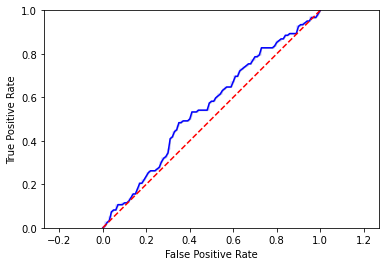

In [ ]:
# Calculate ROC curves for each run
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
from scipy import interp
import sklearn

# EDIT MODEL PATHS TO USE
models = {0: '/content/models/0/020--0.555--0.516.hdf5'
          }

tprs = []
base_fpr = np.linspace(0, 1, 101)
for iii in range(1):
  print(iii)

  test_features= DATA[iii]['MFCCS'][ int(0.7*len(data_x)): int(0.85*len(data_x))]
  test_extra   = DATA[iii]['EXTRA'][ int(0.7*len(data_x)): int(0.85*len(data_x))]
  test_imgs    = DATA[iii]['MEL'][ int(0.7*len(data_x)): int(0.85*len(data_x))]
  test_labels  = DATA[iii]['LABELS'][ int(0.7*len(data_x)): int(0.85*len(data_x))]
  TEST          = TripleInputGenerator(test_features,test_imgs,test_extra,test_labels,batch_size=48,target_size=(64,64))

  model = keras.models.load_model(models[iii])
  y_score = model.predict(TEST)
  fpr, tpr, _ = roc_curve(test_labels[:len(y_score)], y_score)
  print('Num_samples:', len(y_score))

  print('acc: ', sklearn.metrics.accuracy_score(test_labels[:len(y_score)], y_score>0.5))

  plt.plot(fpr, tpr, 'b', alpha=0.15)
  tpr = interp(base_fpr, fpr, tpr)
  tpr[0] = 0.0
  tprs.append(tpr)

tprs = np.array(tprs)
mean_tprs = tprs.mean(axis=0)
std = tprs.std(axis=0)

tprs_upper = np.minimum(mean_tprs + std, 1)
tprs_lower = mean_tprs - std

plt.plot(base_fpr, mean_tprs, 'b')
plt.fill_between(base_fpr, tprs_lower, tprs_upper, color='grey', alpha=0.3)

plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.axes().set_aspect('equal', 'datalim')
plt.savefig('roc_curve.png')
plt.show()